In [5]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tidalsim.modeling.extrapolation as tme

import importlib
importlib.reload(tme)

<module 'tidalsim.modeling.extrapolation' from '/scratch/vighneshiyer/chipyard/tools/tidalsim/tidalsim/modeling/extrapolation.py'>

In [104]:
from pathlib import Path
from typing import Tuple, List
import logging

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from tidalsim.util.pickle import load
logging.basicConfig(format='%(levelname)s - %(filename)s:%(lineno)d - %(message)s', level=logging.INFO)

def analyze_tidalsim_results(run_dir: Path, interval_length: int, clusters: int) -> pd.DataFrame:
    interval_dir = run_dir / f"n_{interval_length}"
    cluster_dir = interval_dir / f"c_{clusters}"

    kmeans_model_file = cluster_dir / "kmeans.model"
    kmeans_model: KMeans
    checkpoint_idxs: np.ndarray
    checkpoint_insts: List[int]
    kmeans_model, checkpoint_idxs, checkpoint_insts = load(kmeans_model_file)

    # For every centroid, get its IPC
    perf_files = [cluster_dir / "checkpoints" / f"0x80000000.{x*interval_length}" / "perf.csv" for x in checkpoint_idxs]
    sample_ipc = np.empty(len(perf_files))
    for i, perf_file in enumerate(perf_files):
        perf_data = pd.read_csv(perf_file)
        perf_data['ipc'] = perf_data['instret'] / perf_data['cycles']
        # Skip the first perf metric sample
        # TODO: generalize this with a detailed warmup argument specified in terms of instructions
        ipc = np.nanmean(perf_data['ipc'][1:])
        sample_ipc[i] = ipc
    logging.info(f"IPC for each centroid: {sample_ipc}")

    # Reconstruct the IPC trace of the entire program
    labels = kmeans_model.labels_ # each label maps an interval in the full program trace to its cluster
    perf_data = pd.DataFrame({'ipc' : sample_ipc[labels], 'instret': np.repeat(interval_length, len(labels))})
    perf_data['inst_count'] = np.cumsum(perf_data['instret'].to_numpy())
    perf_data_new = pd.DataFrame(np.repeat(perf_data.values, 2, axis=0))
    perf_data_new.columns = perf_data.columns
    perf_data_new['inst_count'][::2] = perf_data_new['inst_count'][::2]- interval_length
    return perf_data_new

def parse_reference_perf(perf_csv: Path, interval_length: int) -> pd.DataFrame:
    perf_data = pd.read_csv(perf_csv)
    perf_data['ipc'] = perf_data['instret'] / perf_data['cycles']
    perf_data['inst_count'] = np.cumsum(perf_data['instret'].to_numpy())
    perf_data_new = pd.DataFrame(np.repeat(perf_data.values, 2, axis=0))
    perf_data_new.columns = perf_data.columns
    perf_data_new['inst_count'][::2] = perf_data_new['inst_count'][::2]- interval_length
    return perf_data_new

In [114]:
def get_run_dir(binary: str) -> Path:
    return Path.cwd().parent / "runs" / binary

interval_length = 1000
clusters = 12
run_dir = get_run_dir("aha-mont64-fb8c96bc")
perf_data_tidalsim = analyze_tidalsim_results(run_dir, interval_length, clusters)

In [115]:
perf_data_reference = parse_reference_perf(Path.cwd().parent.parent.parent / "sims" / "vcs" / "aha-mont64_perf.csv", interval_length)

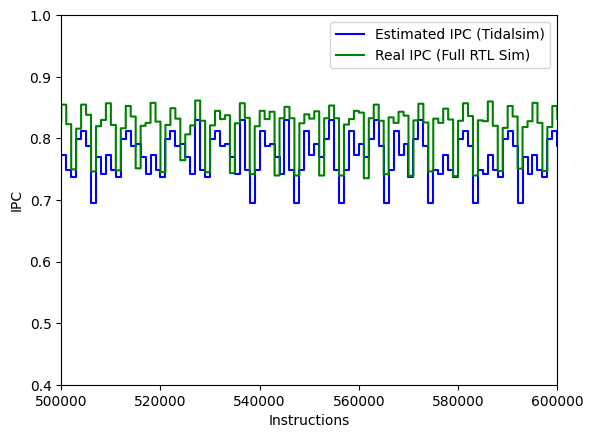

In [117]:
plt.plot(perf_data_tidalsim['inst_count'], perf_data_tidalsim['ipc'], 'b')
plt.plot(perf_data_reference['inst_count'], perf_data_reference['ipc'], 'g')
plt.xlabel('Instructions')
plt.ylabel('IPC')
plt.xlim([0.5e6,0.6e6])
plt.ylim([0.4, 1.0])
plt.legend(['Estimated IPC (Tidalsim)', 'Real IPC (Full RTL Sim)'])